# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Momentum in US Treasury Bond ETF

In this notebook, you will learn to analyse the patterns in treasury bond prices. These patterns produce significant average returns which increase with maturity. And momentum can be attributed to an increase in investor demand for treasuries due to window dressing and portfolio rebalancing.

After completing the notebook, you will be able to 
1. Read data from a CSV file
2. Use datetime properties
3. Examine the days with excess returns
4. Compute strategy returns, CAGR, and drawdowns 
4. Plot cumulative strategy returns and drawdowns


In this notebook, you will perform the following steps:

1. [Read the data](#read)
2. [Count the days from end of month](#counting)
3. [Analyse the return patterns](#analyse)
3. [Percentage of days with positive returns](#days_with_positive)
3. [Trading logic](#trading_logic)
3. [Strategy returns](#strategy_returns)
3. [Drawdowns](#drawdowns)
4. [Tweak the code](#tweak)

<a id='read'></a> 
## Read the data
The close price data for the US Treasury Bond ETF is stored in the CSV file. To read a CSV file, you can use `read_csv` method of `pandas`. The syntax is shown below.

Syntax: 
```python
import pandas as pd
pd.read_csv(filename,index_col)
```
1. **filename**: name of the file in the string format
2. **index_col**: the column number to set as index

This data is available in the downloadable unit of this course in the last section. You can also download treasury ETFs data from finance.yahoo.com.

We will be using the following three ETFs

iShares 1-3 Year Treasury Bond ETF (SHY) - This ETF tracks the results of an index composed of U.S. Treasury bonds with remaining maturities between one and three years.

iShares 7-10 Year Treasury Bond ETF (IEF) - This ETF tracks the results of an index composed of U.S. Treasury bonds with remaining maturities between seven and ten years.

iShares 20+ Year Treasury Bond ETF - This ETF tracks the results of an index composed of U.S. Treasury bonds with remaining maturities greater than 20 years.

You will then use the `pct.change()` function to retrieve the daily returns of the three assets.


In [12]:
import pandas as pd
# The data is stored in the directory 'data'
path = '../data/'

# Read the csv file using read_csv method of pandas
data = pd.read_csv(path +'treasury_prices_2002_2020.csv', index_col=0)
data.index = pd.to_datetime(data.index,format='%Y-%m-%d')

# Calculate daily percentage changes of the prices
data = data.pct_change()

data.tail()

,SHY,IEF,TLT
Date,,,
2020-05-14,-0.000231,0.001559,0.009787
2020-05-15,0.000577,-0.000656,-0.002573
2020-05-18,-0.000808,-0.006150,-0.021954
2020-05-19,0.000577,0.002805,0.003741
2020-05-20,0.000000,0.000247,0.002994


<a id='counting'></a> 
## Count days from end of month

The excess returns are present at the end of the month. We will find the last trading day of the month and mark it as Day 0, find second last day of the month and mark it as -1 and so on.

The logic for this is as follows.

1. **Find the last day of the month**: If the month of current trading date is different from month of the next trading date then it indicates that the current day is the last trading day. Then find the date of last trading day.
2. **Count days from last day**: 
Take the difference of current date and last day of month to get the day number from the last date of the month.

The following methods/properties are used.

1. `shift`: To shift the values in dataframe. Once the values are shifted by a day, the != operator is to compare current day's month with next day's month.

2. `date.day`: The day property on the date datatype is used to extract the date from it. For example, when day is called on '29-Jan-2020', it returns 29.

2. `fillna`: To backfill the missing values. This is use to populate the last trading date to all values in the month.

2. `where`: This is used for conditional assignment of values. If the date is last trading day then date value is extracted from the date index.

Syntax:
```python
import numpy as np
np.where(condition,value_if_true,value_if_false)
```

Parameters

1. condition: Condition to check
2. value_if_true: Value if the condition is satisfied
3. value_if_false: Value if the condition is not satisfied


In [13]:
import numpy as np
# Store month attribute of the day
data['month'] = data.index.month 
# Compare current day's month attribute with next day's month attribute
data['is_last_day'] = data.month != data.month.shift(-1) 
# Store the last date of the month
data['last_date_of_month'] = np.where(data.is_last_day, data.index.day, np.nan) 
data.last_date_of_month = data.last_date_of_month.fillna(method='bfill')
data['days_since_last_day'] = data.index.day - data.last_date_of_month
data.head()

,SHY,IEF,TLT,month,is_last_day,last_date_of_month,days_since_last_day
Date,,,,,,,
2002-07-30,NaN,NaN,NaN,7,False,31.0,-1.0
2002-07-31,0.003086,0.009172,0.012390,7,True,31.0,0.0
2002-08-01,0.001970,0.004120,0.005695,8,False,30.0,-29.0
2002-08-02,0.001964,0.007723,0.010240,8,False,30.0,-28.0
2002-08-05,0.001594,0.005031,0.004413,8,False,30.0,-25.0


In the above output, `is_last_day` for `2002-07-31` is set  to True as it is the last trading of the month. Then value 31 is stored in `last_date_of_month` column. We take the difference of all days with last day of respective months to get the number of days from last date of the month.

***
<a id='analyse'></a> 
## Analyse the returns patterns

You will plot the average returns according to the days of the month. This will help in locating which days are the most profitable.

To plot the returns, you need to import `matplotlib.pyplot` library and use `plot()` function.

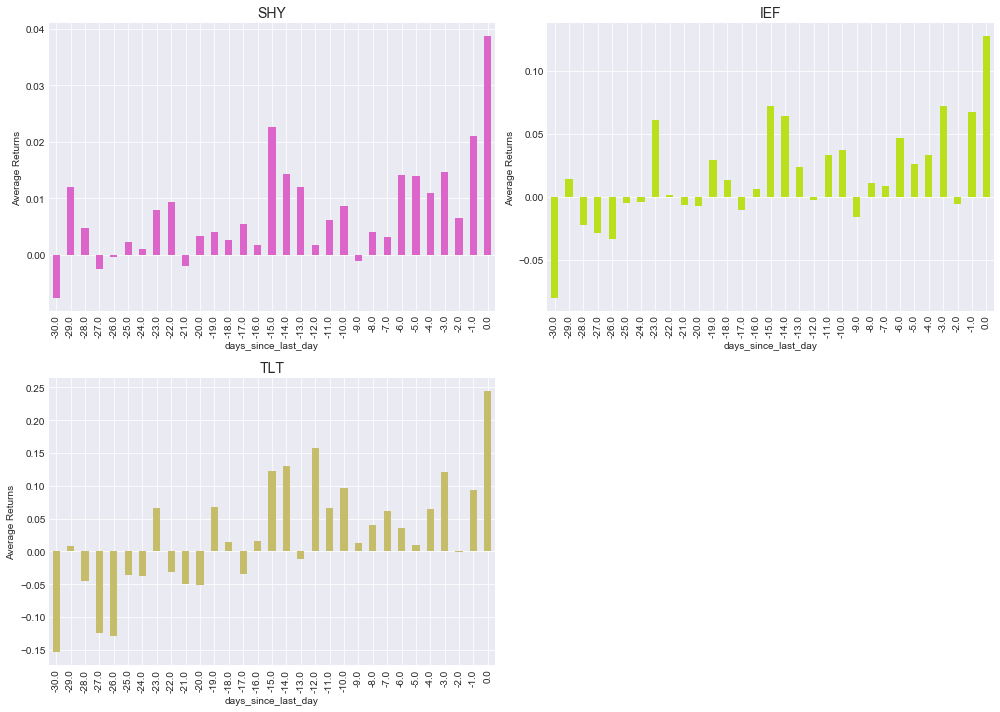

In [14]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(7*2, 5*2))
inst_list = ['SHY', 'IEF', 'TLT']
i = 1
for col in inst_list:
    # Add the subplot
    sub = fig.add_subplot(2, 2, i)
    i = i+1
    # Set title
    sub.set_title(col, fontsize=14)
    # Plot
    r = random.random()
    b = random.random()
    g = random.random()
    (data.groupby('days_since_last_day')[col].mean()*100).plot.bar(color=(r, g, b))
    sub.set_ylabel('Average Returns')

plt.tight_layout()
plt.show()

<img src=https://d2a032ejo53cab.cloudfront.net/Glossary/LG8LGHAy/Screenshot-2020-04-30-at-2.40.27-PM.png width=500></img>
<BR>
*The graph shows the average net purchases of Treasuries by trading days to the end of the month for all U.S. registered insurers. Units are million dollars par value. Source: Predictable End-of-Month Treasury Returns by Jonathan Hartley and Krista Schwarz* <BR>

**As you can see, the treasury bond prices exhibit significant returns on the last days of the month. And if you check the net purchases by U.S. registered insurers, you can see a significant rise at the end of the month. Thus, there is a positive correlation between the net purchases of Treasuries by insurers and Treasuries returns at the End of the Month.**



<a id='days_with_positive'></a> 
## Percentage of days with positive returns

Significantly positive returns on a few days can skew the average returns. For example, abnormally huge returns for the two years out of 10 years can make the average returns more than 0. You have to make sure that the days are profitable on a consistent basis. 

You can check this by counting the number of times the returns were positive or the percentage of time the returns were positive. The threshold for this value will be 50%. That is, you will only consider those days where the returns were positive more than half the time.

The logic is:
1. Group the data by last trading day of the month. That is, all day 0, day -1, and so on are grouped together.
2. Count the number of times the returns were positive. 
3. Count total occurrences.
4. Divide the output of step 2 and 3, to get the percentage of times the returns are positive.

The following methods are used.
1. `groupby`: to group the values by `days_since_last_day`.
2. `sum`: to take the sum of values.
3. `count`: to count the number of values.

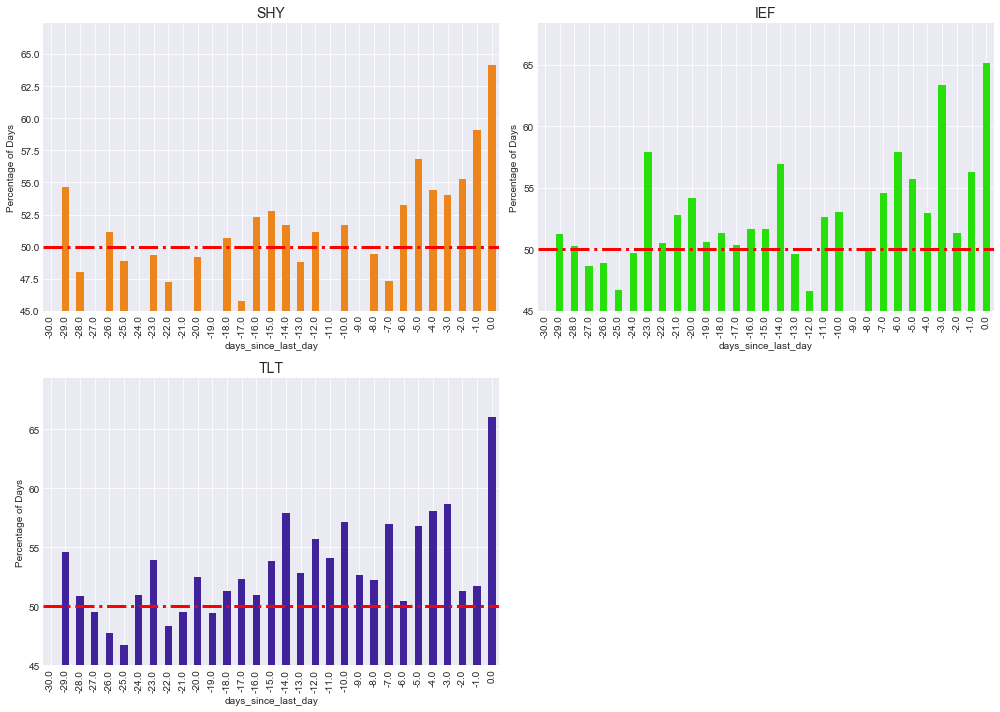

In [15]:
data_replica = data[:]
fig = plt.figure(figsize=(7*2, 5*2))
i = 1
for col in inst_list:
    data_replica[col] = np.where(data_replica[col] > 0, 1, 0)
    days_gt_than_zero_returns = data_replica.groupby(
        'days_since_last_day')[col].sum()
    total_days = data_replica.groupby('days_since_last_day')[col].count()
    percent_days_positive_returns = 100*days_gt_than_zero_returns/total_days

    # Add the subplot
    sub = fig.add_subplot(2, 2, i)
    i = i+1
    r = random.random()
    b = random.random()
    g = random.random()
    percent_days_positive_returns.plot.bar(color=(r, g, b))
    
    # Set title, ylimit and horizontal line at 50% mark
    sub.set_title(col, fontsize=14)
    sub.set_ylim(45)
    sub.set_ylabel('Percentage of Days')
    sub.axhline(50, color='r', linestyle='dashdot', linewidth=3)

plt.tight_layout()
plt.show()

As you can see in the graph, during the end of month, the percentage of positive days are significantly above 50. In particular, the last six days are very prominent. The last day has the most number of days with positive returns.

Thus, you can now clearly see that the end of the month effect exists in treasuries. If you consider that treasuries are relatively less risky, then surely you should create a trading strategy around this effect.

***
<a id='trading_logic'></a> 
## Trading logic

You have seen that the last six days of the month give large returns. You will create the trading strategy to buy the treasuries 6 days before the end of the month. 

You will use the `numpy.where()` function to generate a trading signal when the day is 6 days or less than 6 days before the end of the month.

In [16]:
data['signal'] = np.where(data.days_since_last_day >= -6, 1, 0)

<a id='strategy_returns'></a> 
## Strategy returns

Once you create the trading signal, now you calculate the returns only on those days when the trading signal returns a buy signal, in this case, 1.

To calculate strategy returns, multiply returns in `data[inst_list]` with `data['signal']`. Then, we use `cumprod()` function to calculate cumulative strategy returns.

In [17]:
# Calculate strategy returns
returns = data[inst_list].mul(data['signal'], axis=0)
returns.head()

,SHY,IEF,TLT
Date,,,
2002-07-30,NaN,NaN,NaN
2002-07-31,0.003086,0.009172,0.01239
2002-08-01,0.000000,0.000000,0.00000
2002-08-02,0.000000,0.000000,0.00000
2002-08-05,0.000000,0.000000,0.00000


In [18]:
# Calculate cumulative strategy returns
cumulative_strategy_returns = ((returns + 1).cumprod())

# Calculate strategy returns
total_strategy_returns = (cumulative_strategy_returns.iloc[-1]-1)*100

total_strategy_returns

SHY     21.375087
IEF     82.045924
TLT    163.679357
Name: 2020-05-20 00:00:00, dtype: float64

In [19]:
# Total number of trading days
days = len(cumulative_strategy_returns)

# Calculate compounded annual growth rate
cagr = (cumulative_strategy_returns.iloc[-1]**(252/days)-1)*100

print('The CAGR from strategy is')
cagr

The CAGR from strategy is


SHY    1.094625
IEF    3.424189
TLT    5.600118
Name: 2020-05-20 00:00:00, dtype: float64

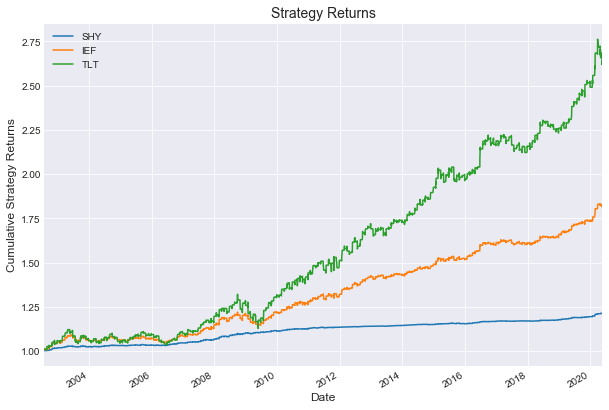

In [9]:
# Plot cumulative strategy returns
cumulative_strategy_returns.plot(figsize=(10, 7))

# Define label for the title of the figure
plt.title('Strategy Returns', fontsize=14)

# Define labels for x-axis and y-axis
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Strategy Returns', fontsize=12)

plt.show()

<a id='drawdowns'></a> 
## Drawdowns

Drawdown can be defined as the percentage loss from the highest cumulative historical point.

The formula to calculate drawdown:

**Drawdown = (cumulative returns/ running maximum) - 1**

To calculate the running maximum, we can use `maximum()` and `accumulate()` functions

In [10]:
def calc_drawdown(cum_rets):

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown


drawdown = calc_drawdown(cumulative_strategy_returns)
max_dd = drawdown.min()*100

max_dd

SHY    -0.641883
IEF    -7.301737
TLT   -14.575357
dtype: float64

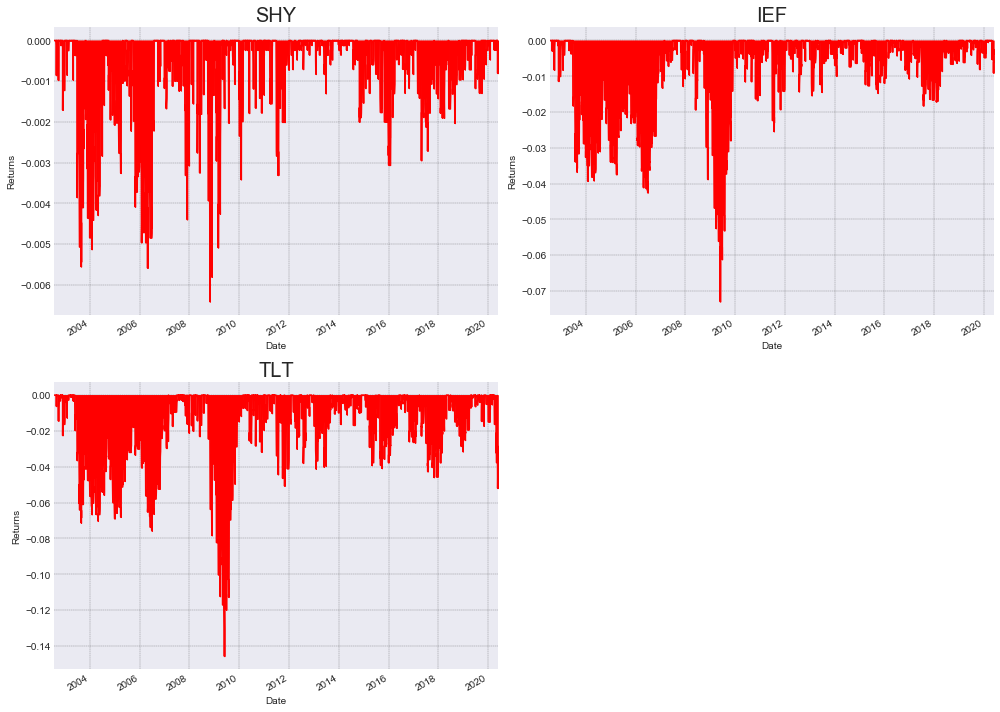

In [11]:
def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(7*2, 5*2))
    i = 1
    for col in drawdown.columns:
        # Add the subplot
        sub = fig.add_subplot(2, 2, i)
        i = i+1
        # Set title
        sub.set_title(col, fontsize=20)
        # Plot

        drawdown[col].plot(color='r')
        sub.set_ylabel('Returns')
        sub.fill_between(drawdown.index, drawdown[col], color='red')
        sub.grid(which="major", color='k', linestyle='-.', linewidth=0.2)

    plt.tight_layout()
    plt.show()


plot_drawdown(drawdown)

Thus, going long on the last 6 days of the month gives decent returns along with a low drawdowns in this strategy. Of course, changing factors such as the number of days or the ETFs could lead to significant changes in the maximum returns of this strategy.

You can decide which combination is best for you. While some prefer the asset with the most returns, others would prefer the one with the least amount of risk, ie minimum drawdowns. There are also individuals who prefer the optimal risk to reward ratio. Thus, you can decide what works best for you.
<a id="tweak"></a>
## Tweak the code
You can tweak the code in the following ways:

1. Try this anomaly on different maturity Treasury Bond ETF
2. Features: Use different number of days such as last two days and analyse the performance
3. Change the trading strategy as you wish.

In the next unit, you will be able to explain the futures markets.
<br><br>

In [22]:
data['inst_list'].head()

KeyError: 'inst_list'